#PREPROCESSING DATA

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import jarque_bera, norm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 100

print("="*70)
print("REGRESI LINEAR BERGANDA (SEMUA VARIABEL) + TRIMMING IQR + ROBUST SE HC3")
print("="*70)

# Load data
train_df = pd.read_csv("train_dataset.csv")
test_df  = pd.read_csv("test_dataset_no_y.csv")

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)

TARGET   = "y"
cat_cols = ["x2", "x3", "x5", "x6"]
num_cols = ["x1", "x4", "x7", "x8", "x9", "x10"]


REGRESI LINEAR BERGANDA (SEMUA VARIABEL) + TRIMMING IQR + ROBUST SE HC3
Train shape: (800, 11)
Test  shape: (193, 10)


In [ ]:
train_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.407166,E,W,2.0,M,C,1.127628,-0.657689,-0.415323,76.124758,20.710704
1,44.417166,M,W,1.0,H,C,0.957628,-0.667689,-0.475323,85.834758,94.202404
2,28.047166,M,W,4.0,L,R,0.717628,-1.107689,-0.385323,13.814758,43.043004
3,-0.462834,NaN,W,2.0,L,C,1.717628,-1.547689,-0.425323,29.344758,7.956004
4,42.957166,M,W,3.0,M,C,0.747628,-1.847689,-0.135323,NaN,62.397804


In [ ]:
test_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,16.787166,N,W,2.0,L,C,2.807628,-0.687689,-0.175323,103.314758
1,38.137166,M,NaN,1.0,M,C,2.197628,-0.617689,-0.195323,14.644758
2,20.797166,E,W,1.0,M,S,3.007628,-0.687689,-0.235323,41.574758
3,15.577166,A,W,4.0,M,C,0.707628,-0.827689,-0.125323,107.614758
4,44.677166,M,W,4.0,L,C,3.027628,-0.447689,-0.345323,92.434758


In [ ]:
print("\n[2] CEK MISSING VALUE – TRAIN")
print(train_df.isnull().sum())

print("\n[2] CEK MISSING VALUE – TEST")
print(test_df.isnull().sum())



[2] CEK MISSING VALUE – TRAIN
x1     43
x2     40
x3     38
x4     36
x5     42
x6     39
x7     39
x8     44
x9     37
x10    42
y      42
dtype: int64

[2] CEK MISSING VALUE – TEST
x1      7
x2     10
x3     11
x4     13
x5      8
x6     11
x7     10
x8      6
x9     12
x10     8
dtype: int64



[3] Statistik Deskriptif Awal (y)
count    758.000000
mean      53.993730
std       42.823339
min        5.120804
25%       30.710379
50%       45.788304
75%       65.293729
max      328.493593
Name: y, dtype: float64


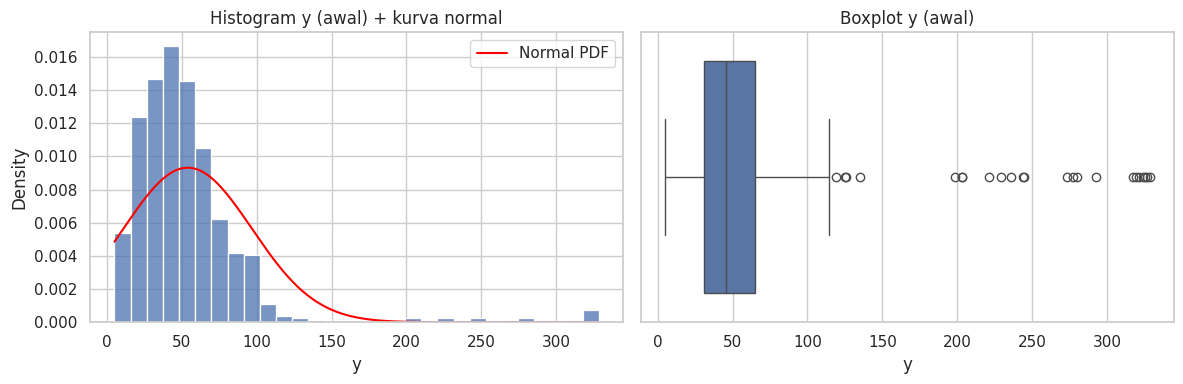

In [ ]:
print("\n[3] Statistik Deskriptif Awal (y)")
print(train_df["y"].describe())

y_raw = train_df["y"].dropna()

plt.figure(figsize=(12, 4))

# Histogram y + kurva normal
plt.subplot(1, 2, 1)
ax = sns.histplot(y_raw, kde=False, stat="density", bins=30)
mean_y = y_raw.mean()
std_y  = y_raw.std()
x_vals = np.linspace(y_raw.min(), y_raw.max(), 200)
pdf    = norm.pdf(x_vals, loc=mean_y, scale=std_y)
plt.plot(x_vals, pdf, color="red", label="Normal PDF")
plt.title("Histogram y (awal) + kurva normal")
plt.legend()

# Boxplot y
plt.subplot(1, 2, 2)
sns.boxplot(x=y_raw)
plt.title("Boxplot y (awal)")

plt.tight_layout()
plt.show()


# PENANGANAN MISSING VALUE & OUTLIER

In [ ]:
# Drop baris yang y-nya hilang
train_df = train_df.dropna(subset=[TARGET]).copy()
print(f"\n[4] Setelah drop missing y: {train_df.shape[0]} observasi")

# Simpan statistik imputasi untuk test
train_stats = {}

# Imputasi kategori dengan modus
for col in cat_cols:
    if col in train_df.columns:
        mode_val = train_df[col].mode()
        if len(mode_val) > 0:
            mode_val = mode_val[0]
            train_stats[f"{col}_mode"] = mode_val
            train_df[col] = train_df[col].fillna(mode_val)

# Imputasi numerik dengan median
for col in num_cols:
    if col in train_df.columns:
        median_val = train_df[col].median()
        train_stats[f"{col}_median"] = median_val
        train_df[col] = train_df[col].fillna(median_val)

print("\n[4] Imputasi kategori (modus) dan numerik (median) selesai")

# Trimming outlier y dengan IQR
Q1 = train_df[TARGET].quantile(0.25)
Q3 = train_df[TARGET].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outlier_mask = (train_df[TARGET] < lower) | (train_df[TARGET] > upper)
n_outliers = outlier_mask.sum()

print(f"\n[4] Deteksi Outlier (IQR 1.5x pada y)")
print(f"    Q1: {Q1:.3f}, Q3: {Q3:.3f}, IQR: {IQR:.3f}")
print(f"    Batas: [{lower:.3f}, {upper:.3f}]")
print(f"    Jumlah outlier: {n_outliers} ({n_outliers/len(train_df)*100:.2f}%)")

train_df = train_df[~outlier_mask].copy()
print(f"    Setelah trimming y: {train_df.shape[0]} observasi")


[4] Setelah drop missing y: 758 observasi

[4] Imputasi kategori (modus) dan numerik (median) selesai

[4] Deteksi Outlier (IQR 1.5x pada y)
    Q1: 30.710, Q3: 65.294, IQR: 34.583
    Batas: [-21.165, 117.169]
    Jumlah outlier: 23 (3.03%)
    Setelah trimming y: 735 observasi


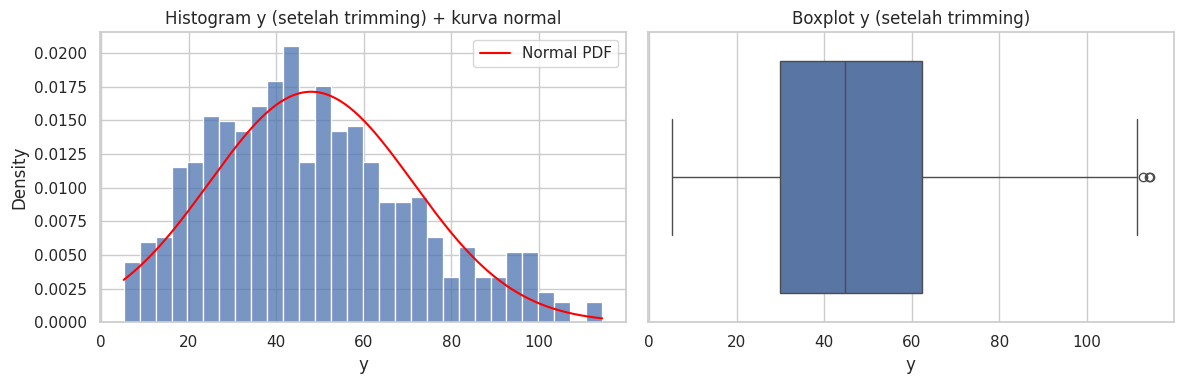

In [ ]:
y_trim = train_df[TARGET]

plt.figure(figsize=(12, 4))

# Histogram y_trim + kurva normal
plt.subplot(1, 2, 1)
ax = sns.histplot(y_trim, kde=False, stat="density", bins=30)
mean_y_t = y_trim.mean()
std_y_t  = y_trim.std()
x_vals   = np.linspace(y_trim.min(), y_trim.max(), 200)
pdf_t    = norm.pdf(x_vals, loc=mean_y_t, scale=std_y_t)
plt.plot(x_vals, pdf_t, color="red", label="Normal PDF")
plt.title("Histogram y (setelah trimming) + kurva normal")
plt.legend()

# Boxplot y_trim
plt.subplot(1, 2, 2)
sns.boxplot(x=y_trim)
plt.title("Boxplot y (setelah trimming)")

plt.tight_layout()
plt.show()


# MODEL REGRESI LINEAR BERGANDA (OLS + HC3)

In [ ]:
feature_cols = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10"]

y_full = train_df[TARGET]
X_full = train_df[feature_cols].copy()

# One-hot encoding variabel kategorik
X_full_encoded = pd.get_dummies(X_full, columns=cat_cols, drop_first=True)

# Train–validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_full_encoded, y_full, test_size=0.2, random_state=42
)

# Samakan kolom antara train dan val
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

print(f"\n[6] Train-Validation Split (80-20)")
print(f"    Train      : {X_train.shape[0]} observasi")
print(f"    Validation : {X_val.shape[0]} observasi")



[6] Train-Validation Split (80-20)
    Train      : 588 observasi
    Validation : 147 observasi


In [ ]:
X_train_const = sm.add_constant(X_train).astype(float)
X_val_const   = sm.add_constant(X_val).astype(float)

model_all = sm.OLS(y_train, X_train_const).fit(cov_type="HC3")

print("\n" + "="*70)
print("RINGKASAN MODEL OLS ROBUST (SEMUA VARIABEL X1–X10)")
print("="*70)
print(model_all.summary())



RINGKASAN MODEL OLS ROBUST (SEMUA VARIABEL X1–X10)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     265.5
Date:                Tue, 30 Dec 2025   Prob (F-statistic):          9.00e-233
Time:                        06:21:08   Log-Likelihood:                -2090.1
No. Observations:                 588   AIC:                             4208.
Df Residuals:                     574   BIC:                             4270.
Df Model:                          13                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


# EVALUASI MODEL

In [ ]:
y_train_pred = model_all.predict(X_train_const)
y_val_pred   = model_all.predict(X_val_const)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_val   = mean_squared_error(y_val, y_val_pred)
target_mse = 88.67

print("\n" + "="*70)
print("EVALUASI PERFORMA (SEMUA VARIABEL)")
print("="*70)
print(f"MSE (Train):      {mse_train:.4f}")
print(f"MSE (Validation): {mse_val:.4f}")
print(f"Target MSE:       {target_mse}")
print(f"Status Train:     {'✓ MEMENUHI' if mse_train <= target_mse else '✗ TIDAK MEMENUHI'}")
print(f"Status Val:       {'✓ MEMENUHI' if mse_val <= target_mse else '✗ TIDAK MEMENUHI'}")
print(f"R² (Train):       {model_all.rsquared:.4f}")
print(f"Adj R² (Train):   {model_all.rsquared_adj:.4f}")



EVALUASI PERFORMA (SEMUA VARIABEL)
MSE (Train):      71.6266
MSE (Validation): 76.8230
Target MSE:       88.67
Status Train:     ✓ MEMENUHI
Status Val:       ✓ MEMENUHI
R² (Train):       0.8668
Adj R² (Train):   0.8637


# UJI ASUMSI

In [ ]:
print("\n" + "="*70)
print("UJI ASUMSI KLASIK (MODEL SEMUA VARIABEL)")
print("="*70)

resid = model_all.resid

# Normalitas
jb_stat, jb_p = jarque_bera(resid)
print(f"\n[A] Uji Normalitas (Jarque-Bera)")
print(f"    Statistik: {jb_stat:.4f}")
print(f"    p-value :  {jb_p:.6f}")

# VIF: semua fitur (numerik + dummy)
X_vif = X_train_const.copy()
vif_data = pd.DataFrame({
    "Variabel": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i)
            for i in range(X_vif.shape[1])]
})
max_vif = vif_data["VIF"].max()
print(f"\n[B] Uji Multikolinearitas (VIF, numerik + kategorik terenkode)")
print(vif_data.to_string(index=False))
print(f"    VIF Maksimum (abaikan const): {max_vif:.4f}")

# Heteroskedastisitas
bp_stat, bp_p, bp_f, bp_f_p = het_breuschpagan(resid, X_train_const)
print(f"\n[C] Uji Heteroskedastisitas (Breusch-Pagan)")
print(f"    LM Statistik: {bp_stat:.4f}")
print(f"    p-value    :  {bp_p:.6f}")

# Autokorelasi
dw = sm.stats.durbin_watson(resid)
print(f"\n[D] Uji Autokorelasi (Durbin-Watson)")
print(f"    DW Statistik: {dw:.4f}")



UJI ASUMSI KLASIK (MODEL SEMUA VARIABEL)

[A] Uji Normalitas (Jarque-Bera)
    Statistik: 78.0436
    p-value :  0.000000

[B] Uji Multikolinearitas (VIF, numerik + kategorik terenkode)
Variabel       VIF
   const 40.619657
      x1  1.042909
      x4  1.007296
      x7  1.014628
      x8  1.029043
      x9  1.017088
     x10  1.017779
    x2_E  1.220368
    x2_M  1.224857
    x2_N  1.158082
    x5_L  1.878853
    x5_M  1.827935
    x6_R  1.035925
    x6_S  1.030651
    VIF Maksimum (abaikan const): 40.6197

[C] Uji Heteroskedastisitas (Breusch-Pagan)
    LM Statistik: 10.7966
    p-value    :  0.627850

[D] Uji Autokorelasi (Durbin-Watson)
    DW Statistik: 2.0371


# VISUALISASI RESIDUAL

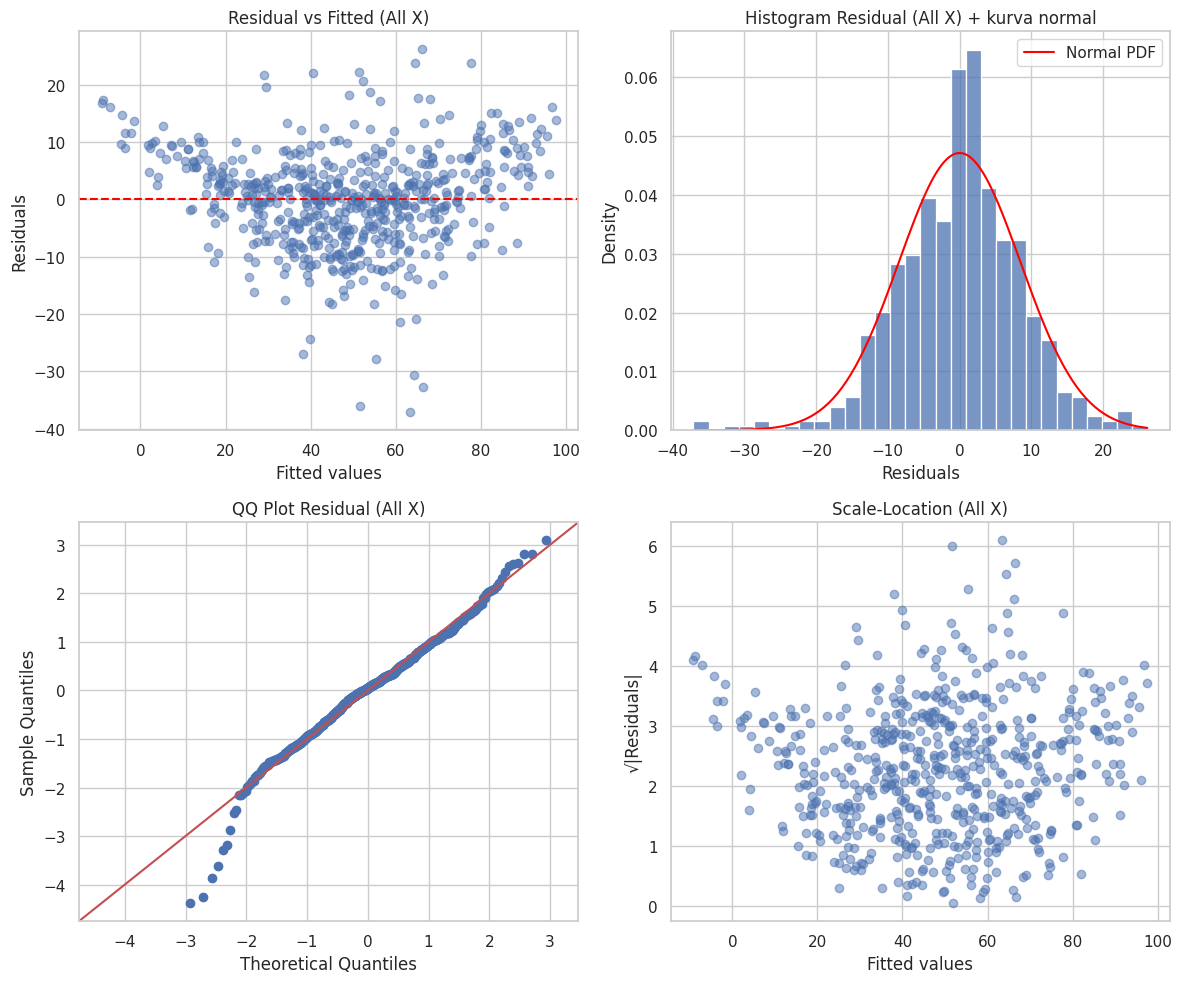

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Residual vs Fitted
axes[0, 0].scatter(y_train_pred, resid, alpha=0.5)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_xlabel("Fitted values")
axes[0, 0].set_ylabel("Residuals")
axes[0, 0].set_title("Residual vs Fitted (All X)")

# Histogram residual + kurva normal
ax = axes[0, 1]
sns.histplot(resid, kde=False, stat="density", bins=30, ax=ax)
mean_r = resid.mean()
std_r  = resid.std()
x_vals = np.linspace(resid.min(), resid.max(), 200)
pdf_r  = norm.pdf(x_vals, loc=mean_r, scale=std_r)
ax.plot(x_vals, pdf_r, color="red", label="Normal PDF")
ax.set_xlabel("Residuals")
ax.set_ylabel("Density")
ax.set_title("Histogram Residual (All X) + kurva normal")
ax.legend()

# QQ Plot
sm.qqplot(resid, line='45', fit=True, ax=axes[1, 0])
axes[1, 0].set_title("QQ Plot Residual (All X)")

# Scale-Location
axes[1, 1].scatter(y_train_pred, np.sqrt(np.abs(resid)), alpha=0.5)
axes[1, 1].set_xlabel("Fitted values")
axes[1, 1].set_ylabel("√|Residuals|")
axes[1, 1].set_title("Scale-Location (All X)")

plt.tight_layout()
plt.show()


# PREDIKSI TEST SET

In [ ]:
print("\n" + "="*70)
print("PREDIKSI UNTUK TEST SET (SEMUA VARIABEL)")
print("="*70)

test_processed = test_df.copy()

# Imputasi test sama seperti train
for col in cat_cols:
    if col in test_processed.columns and f"{col}_mode" in train_stats:
        test_processed[col] = test_processed[col].fillna(train_stats[f"{col}_mode"])

for col in num_cols:
    if col in test_processed.columns and f"{col}_median" in train_stats:
        test_processed[col] = test_processed[col].fillna(train_stats[f"{col}_median"])

test_X = test_processed[feature_cols].copy()
test_X_encoded = pd.get_dummies(test_X, columns=cat_cols, drop_first=True)

# Samakan kolom dengan X_train
test_X_encoded = test_X_encoded.reindex(columns=X_train.columns, fill_value=0)
test_X_const   = sm.add_constant(test_X_encoded).astype(float)

y_test_pred = model_all.predict(test_X_const)

print(f"[11] Prediksi selesai untuk {len(test_X_encoded)} observasi test")
print(f"     Range prediksi: [{y_test_pred.min():.2f}, {y_test_pred.max():.2f}]")

submission_all = pd.DataFrame({
    "ID": np.arange(1, len(y_test_pred) + 1),
    "y": y_test_pred
})
submission_all.to_csv("submission_allvars_robust.csv", index=False)
print("\n[12] File submission_allvars_robust.csv berhasil dibuat!")
print(submission_all.head(10).to_string(index=False))



PREDIKSI UNTUK TEST SET (SEMUA VARIABEL)
[11] Prediksi selesai untuk 193 observasi test
     Range prediksi: [-18.15, 151.44]

[12] File submission_allvars_robust.csv berhasil dibuat!
 ID          y
  1  72.664345
  2  76.044292
  3  61.489949
  4  73.657743
  5 102.400845
  6  56.897951
  7  21.153080
  8  39.226844
  9  35.608418
 10  71.912278


# MODEL LANJUTAN (TURUNAN)

## POLYNOMIAL (MODEL A)


In [43]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import jarque_bera, norm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 100

TARGET = "y"
feature_cols = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10"]

# train_df sudah dalam kondisi: drop missing y, imputasi, trimming IQR
y_full = train_df[TARGET]
X_full = train_df[feature_cols].copy()

# One-hot encoding
X_full_encoded = pd.get_dummies(X_full, columns=cat_cols, drop_first=True)
base_cols = X_full_encoded.columns.tolist()

print("Shape X_full_encoded:", X_full_encoded.shape)

Shape X_full_encoded: (735, 13)


In [44]:
X_poly = X_full_encoded.copy()

# Polynomial (kuadrat) untuk variabel kuat
for col in ["x1", "x8", "x9", "x10"]:
    if col in X_poly.columns:
        X_poly[f"{col}_sq"] = X_poly[col]**2

# Interaksi antar variabel kuat
if "x1" in X_poly.columns and "x8" in X_poly.columns:
    X_poly["x1_x8"] = X_poly["x1"] * X_poly["x8"]
if "x1" in X_poly.columns and "x9" in X_poly.columns:
    X_poly["x1_x9"] = X_poly["x1"] * X_poly["x9"]
if "x8" in X_poly.columns and "x9" in X_poly.columns:
    X_poly["x8_x9"] = X_poly["x8"] * X_poly["x9"]

print("Shape X_poly:", X_poly.shape)


Shape X_poly: (735, 20)


In [45]:
# Split train-validation
X_train_A, X_val_A, y_train_A, y_val_A = train_test_split(
    X_poly, y_full, test_size=0.2, random_state=42
)

X_train_const_A = sm.add_constant(X_train_A).astype(float)
X_val_const_A   = sm.add_constant(X_val_A).astype(float)

# OLS dengan HC3
model_A = sm.OLS(y_train_A, X_train_const_A).fit(cov_type="HC3")

print("\n" + "="*70)
print("MODEL A: OLS ROBUST (POLYNOMIAL + INTERAKSI)")
print("="*70)
print(model_A.summary())

# Evaluasi MSE
y_train_pred_A = model_A.predict(X_train_const_A)
y_val_pred_A   = model_A.predict(X_val_const_A)

mse_train_A = mean_squared_error(y_train_A, y_train_pred_A)
mse_val_A   = mean_squared_error(y_val_A, y_val_pred_A)

print("\nMSE Train (Model A):     ", mse_train_A)
print("MSE Validation (Model A):", mse_val_A)

# Uji asumsi klasik
resid_A = model_A.resid

# Normalitas
jb_stat_A, jb_p_A = jarque_bera(resid_A)
print("\n[Assumption] Jarque-Bera p-value (Model A):", jb_p_A)

# Heteroskedastisitas
bp_stat_A, bp_p_A, _, _ = het_breuschpagan(resid_A, X_train_const_A)
print("[Assumption] Breusch-Pagan p-value (Model A):", bp_p_A)

# Multikolinearitas (VIF)
X_vif_A = X_train_const_A.copy()
vif_A = pd.DataFrame({
    "Variabel": X_vif_A.columns,
    "VIF": [variance_inflation_factor(X_vif_A.values, i)
            for i in range(X_vif_A.shape[1])]
})
print("\n[Assumption] VIF (Model A):")
print(vif_A)

# Autokorelasi
dw_A = sm.stats.durbin_watson(resid_A)
print("\n[Assumption] Durbin-Watson (Model A):", dw_A)



MODEL A: OLS ROBUST (POLYNOMIAL + INTERAKSI)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     571.6
Date:                Tue, 30 Dec 2025   Prob (F-statistic):               0.00
Time:                        06:55:59   Log-Likelihood:                -1922.2
No. Observations:                 588   AIC:                             3886.
Df Residuals:                     567   BIC:                             3978.
Df Model:                          20                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const 

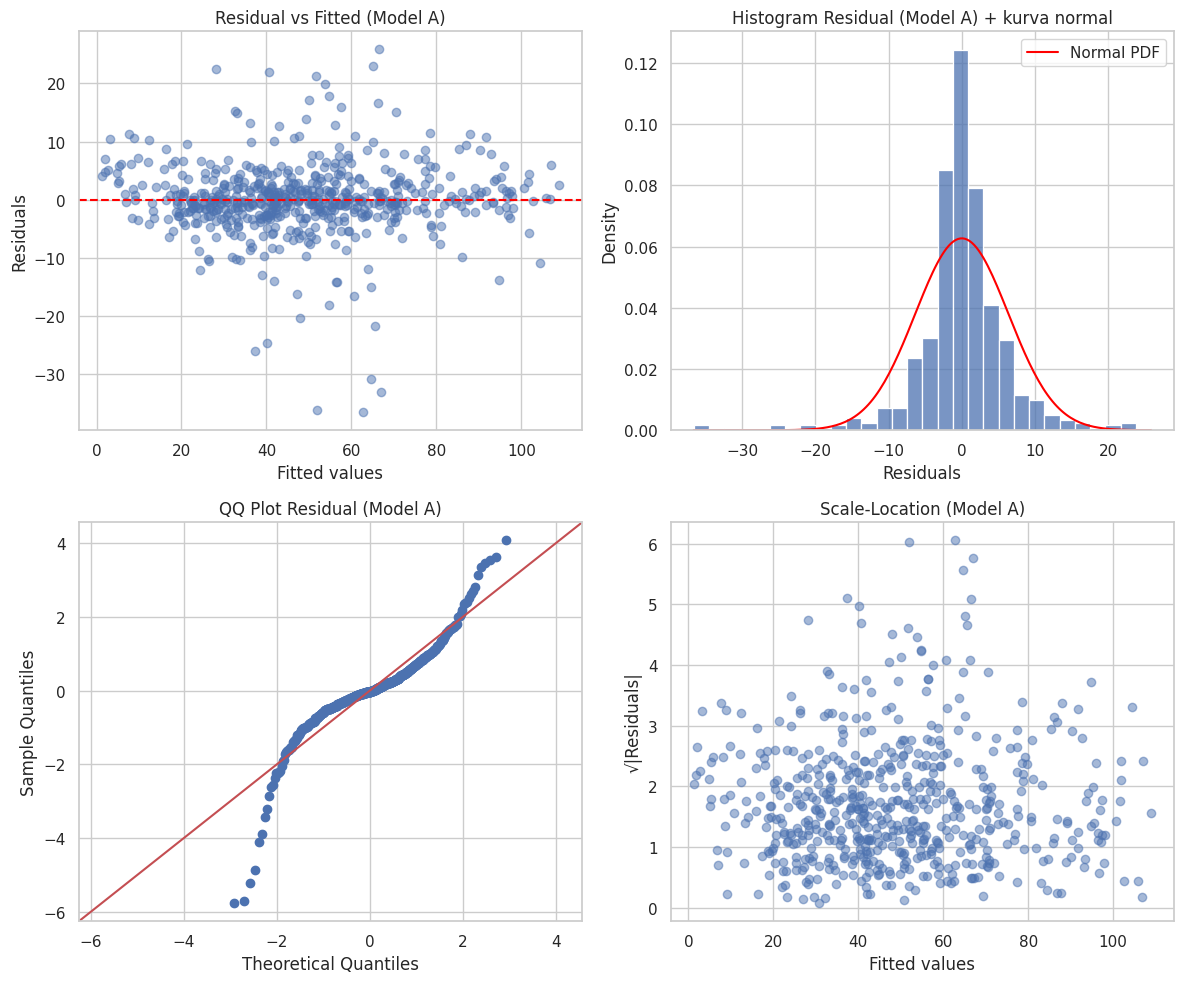

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Residual vs Fitted
axes[0, 0].scatter(y_train_pred_A, resid_A, alpha=0.5)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_xlabel("Fitted values")
axes[0, 0].set_ylabel("Residuals")
axes[0, 0].set_title("Residual vs Fitted (Model A)")

# Histogram residual + kurva normal
ax = axes[0, 1]
sns.histplot(resid_A, kde=False, stat="density", bins=30, ax=ax)
mean_r_A = resid_A.mean()
std_r_A  = resid_A.std()
x_vals   = np.linspace(resid_A.min(), resid_A.max(), 200)
pdf_r_A  = norm.pdf(x_vals, loc=mean_r_A, scale=std_r_A)
ax.plot(x_vals, pdf_r_A, color="red", label="Normal PDF")
ax.set_xlabel("Residuals")
ax.set_ylabel("Density")
ax.set_title("Histogram Residual (Model A) + kurva normal")
ax.legend()

# QQ Plot
sm.qqplot(resid_A, line='45', fit=True, ax=axes[1, 0])
axes[1, 0].set_title("QQ Plot Residual (Model A)")

# Scale-Location
axes[1, 1].scatter(y_train_pred_A, np.sqrt(np.abs(resid_A)), alpha=0.5)
axes[1, 1].set_xlabel("Fitted values")
axes[1, 1].set_ylabel("√|Residuals|")
axes[1, 1].set_title("Scale-Location (Model A)")

plt.tight_layout()
plt.show()

## GRADIENT BOOSTING REGRESSOR (MODEL B) TREE - BASED

In [47]:
gbr = GradientBoostingRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.9,
    random_state=42
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores_B = -cross_val_score(
    gbr, X_poly, y_full,
    cv=cv,
    scoring="neg_root_mean_squared_error"
)

print("\nCross-val RMSE (Model B / GBR, y asli):", rmse_scores_B.mean())


Cross-val RMSE (Model B / GBR, y asli): 6.43853450779599


In [48]:
gbr.fit(X_poly, y_full)

# Prediksi full train untuk lihat korelasi error
y_pred_A_full = model_A.predict(sm.add_constant(X_poly).astype(float))
y_pred_B_full = gbr.predict(X_poly)

print("Corr(pred Model A, pred Model B):", np.corrcoef(y_pred_A_full, y_pred_B_full)[0, 1])

Corr(pred Model A, pred Model B): 0.9781205154151535


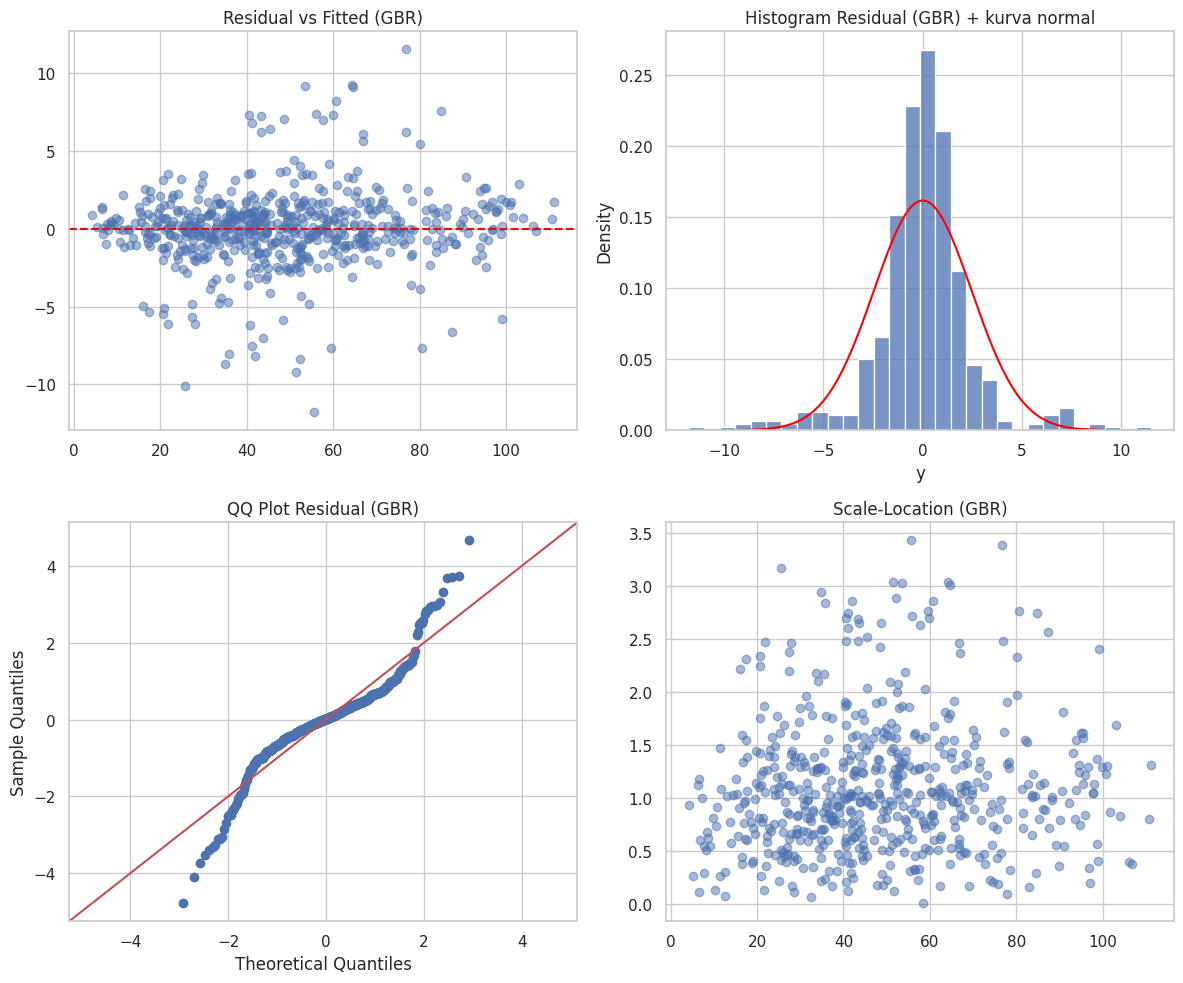

In [58]:
gbr.fit(X_train_A, y_train_A)

y_train_pred_B = gbr.predict(X_train_A)
resid_B = y_train_A - y_train_pred_B

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].scatter(y_train_pred_B, resid_B, alpha=0.5)
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_title("Residual vs Fitted (GBR)")

ax = axes[0,1]
sns.histplot(resid_B, kde=False, stat="density", bins=30, ax=ax)
mean_r = resid_B.mean()
std_r  = resid_B.std()
x_vals = np.linspace(resid_B.min(), resid_B.max(), 200)
pdf_r  = norm.pdf(x_vals, loc=mean_r, scale=std_r)
ax.plot(x_vals, pdf_r, color="red")
ax.set_title("Histogram Residual (GBR) + kurva normal")

sm.qqplot(resid_B, line='45', fit=True, ax=axes[1,0])
axes[1,0].set_title("QQ Plot Residual (GBR)")

axes[1,1].scatter(y_train_pred_B, np.sqrt(np.abs(resid_B)), alpha=0.5)
axes[1,1].set_title("Scale-Location (GBR)")

plt.tight_layout()
plt.show()

## MODEL ENSEMBLE

In [65]:
# ==========================
# PREPARASI TEST
# ==========================
test_processed = test_df.copy()

for col in cat_cols:
    if col in test_processed.columns and f"{col}_mode" in train_stats:
        test_processed[col] = test_processed[col].fillna(train_stats[f"{col}_mode"])

for col in num_cols:
    if col in test_processed.columns and f"{col}_median" in train_stats:
        test_processed[col] = test_processed[col].fillna(train_stats[f"{col}_median"])

test_X = test_processed[feature_cols].copy()
test_X_encoded = pd.get_dummies(test_X, columns=cat_cols, drop_first=True)

# Samakan kolom dengan X_full_encoded
test_X_encoded = test_X_encoded.reindex(columns=base_cols, fill_value=0)

# Tambahkan polynomial & interaksi
test_X_poly = test_X_encoded.copy()

for col in ["x1", "x8", "x9", "x10"]:
    if col in test_X_poly.columns:
        test_X_poly[f"{col}_sq"] = test_X_poly[col]**2

if "x1" in test_X_poly.columns and "x8" in test_X_poly.columns:
    test_X_poly["x1_x8"] = test_X_poly["x1"] * test_X_poly["x8"]
if "x1" in test_X_poly.columns and "x9" in test_X_poly.columns:
    test_X_poly["x1_x9"] = test_X_poly["x1"] * test_X_poly["x9"]
if "x8" in test_X_poly.columns and "x9" in test_X_poly.columns:
    test_X_poly["x8_x9"] = test_X_poly["x8"] * test_X_poly["x9"]

# Samakan kolom dengan X_poly (train)
test_X_poly = test_X_poly.reindex(columns=X_poly.columns, fill_value=0)

# ==========================
# PREDIKSI
# ==========================
# Model A (linear polynomial + HC3)
test_X_poly_const = sm.add_constant(test_X_poly).astype(float)
y_test_A = model_A.predict(test_X_poly_const)

# Model B (GBR)
y_test_B = gbr.predict(test_X_poly)

# Ensemble
w_A = 0.5
w_B = 0.5
y_test_ens = w_A * y_test_A + w_B * y_test_B

submission_A = pd.DataFrame({"ID": np.arange(1, len(y_test_A) + 1), "y": y_test_A})
submission_B = pd.DataFrame({"ID": np.arange(1, len(y_test_B) + 1), "y": y_test_B})
submission_E = pd.DataFrame({"ID": np.arange(1, len(y_test_ens) + 1), "y": y_test_ens})

submission_A.to_csv("submission_modelA_ols_poly.csv", index=False)
submission_B.to_csv("submission_modelB_gbr.csv", index=False)
submission_E.to_csv("submission_modelAB_ensemble.csv", index=False)

print("File submission_modelA_ols_poly.csv, submission_modelB_gbr.csv, dan submission_modelAB_ensemble.csv berhasil dibuat.")
print(submission_A.head(10))
print(submission_B.head(10))
print(submission_E.head())

File submission_modelA_ols_poly.csv, submission_modelB_gbr.csv, dan submission_modelAB_ensemble.csv berhasil dibuat.
   ID           y
0   1   72.204147
1   2   83.843564
2   3   60.136095
3   4   71.896355
4   5  119.821257
5   6   46.808182
6   7   20.982868
7   8   29.983954
8   9   24.714269
9  10   72.757305
   ID           y
0   1   81.103722
1   2   77.733497
2   3   56.375166
3   4   78.321968
4   5  117.242851
5   6   49.446317
6   7   26.273938
7   8   36.239976
8   9   25.511644
9  10   65.946655
   ID           y
0   1   76.653934
1   2   80.788530
2   3   58.255631
3   4   75.109162
4   5  118.532054


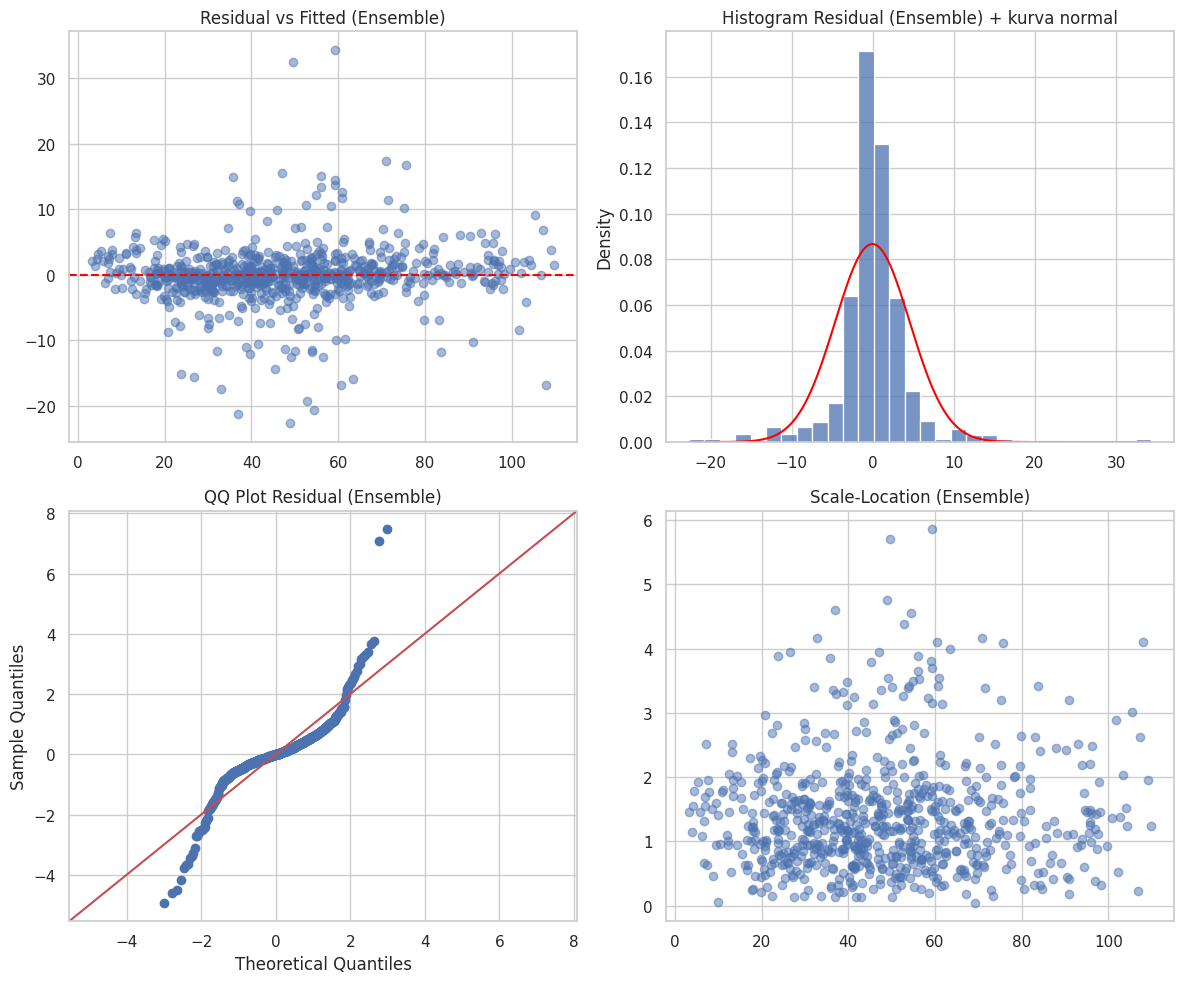

In [78]:
# Misal di train pakai kombinasi model_A (OLS poly) dan gbr
y_pred_A_train = model_A.predict(sm.add_constant(X_poly).astype(float))
y_pred_B_train = gbr.predict(X_poly)

w_A, w_B = 0.5, 0.5
y_pred_ens_train = w_A * y_pred_A_train + w_B * y_pred_B_train
resid_ens = y_full - y_pred_ens_train

# Visualisasi residual ensemble (tanpa VIF/BP/JB formal)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].scatter(y_pred_ens_train, resid_ens, alpha=0.5)
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_title("Residual vs Fitted (Ensemble)")

ax = axes[0,1]
sns.histplot(resid_ens, kde=False, stat="density", bins=30, ax=ax)
mean_r = resid_ens.mean()
std_r  = resid_ens.std()
x_vals = np.linspace(resid_ens.min(), resid_ens.max(), 200)
pdf_r  = norm.pdf(x_vals, loc=mean_r, scale=std_r)
ax.plot(x_vals, pdf_r, color="red")
ax.set_title("Histogram Residual (Ensemble) + kurva normal")

sm.qqplot(resid_ens, line='45', fit=True, ax=axes[1,0])
axes[1,0].set_title("QQ Plot Residual (Ensemble)")

axes[1,1].scatter(y_pred_ens_train, np.sqrt(np.abs(resid_ens)), alpha=0.5)
axes[1,1].set_title("Scale-Location (Ensemble)")

plt.tight_layout()
plt.show()

## RIDGE & LASSO REGRESSION

In [53]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error

# Gunakan X_poly dan y_full (sama seperti Model A)
X_train_R, X_val_R, y_train_R, y_val_R = train_test_split(
    X_poly, y_full, test_size=0.2, random_state=42
)

# RidgeCV dengan grid alpha sederhana
ridge = RidgeCV(alphas=[0.01, 0.1, 1, 10], cv=5)
ridge.fit(X_train_R, y_train_R)

y_val_pred_ridge = ridge.predict(X_val_R)
mse_val_ridge = mean_squared_error(y_val_R, y_val_pred_ridge)

print("Ridge best alpha:", ridge.alpha_)
print("MSE Validation (Ridge):", mse_val_ridge)

# LassoCV
lasso = LassoCV(alphas=[0.001, 0.01, 0.1, 1], cv=5, max_iter=10000, random_state=42)
lasso.fit(X_train_R, y_train_R)

y_val_pred_lasso = lasso.predict(X_val_R)
mse_val_lasso = mean_squared_error(y_val_R, y_val_pred_lasso)

print("\nLasso best alpha:", lasso.alpha_)
print("MSE Validation (Lasso):", mse_val_lasso)

# Berapa banyak koefisien yang != 0 (seleksi variabel otomatis)
print("Jumlah koefisien Lasso ≠ 0:", np.sum(lasso.coef_ != 0))


Ridge best alpha: 0.1
MSE Validation (Ridge): 42.81177833379745

Lasso best alpha: 0.01
MSE Validation (Lasso): 43.37981018419967
Jumlah koefisien Lasso ≠ 0: 19


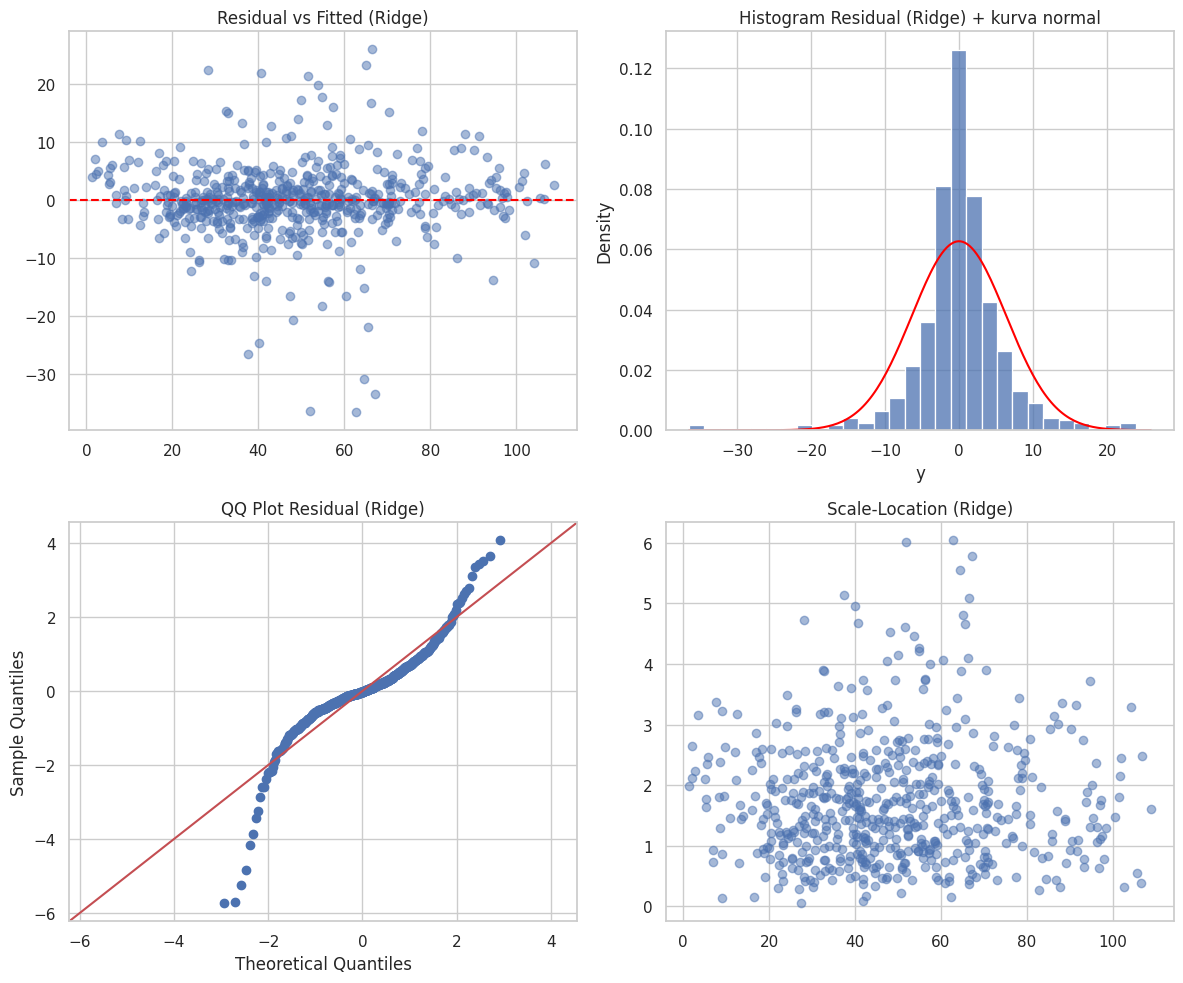

In [57]:
from sklearn.linear_model import RidgeCV, LassoCV

ridge = RidgeCV(alphas=[0.01, 0.1, 1, 10], cv=5)
ridge.fit(X_train_R, y_train_R)

y_train_pred_R = ridge.predict(X_train_R)
resid_R = y_train_R - y_train_pred_R

# Visualisasi residual Ridge
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].scatter(y_train_pred_R, resid_R, alpha=0.5)
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_title("Residual vs Fitted (Ridge)")

ax = axes[0,1]
sns.histplot(resid_R, kde=False, stat="density", bins=30, ax=ax)
mean_r = resid_R.mean()
std_r  = resid_R.std()
x_vals = np.linspace(resid_R.min(), resid_R.max(), 200)
pdf_r  = norm.pdf(x_vals, loc=mean_r, scale=std_r)
ax.plot(x_vals, pdf_r, color="red")
ax.set_title("Histogram Residual (Ridge) + kurva normal")

sm.qqplot(resid_R, line='45', fit=True, ax=axes[1,0])
axes[1,0].set_title("QQ Plot Residual (Ridge)")

axes[1,1].scatter(y_train_pred_R, np.sqrt(np.abs(resid_R)), alpha=0.5)
axes[1,1].set_title("Scale-Location (Ridge)")

plt.tight_layout()
plt.show()

In [62]:
y_test_pred_ridge = ridge.predict(test_X_poly)

submission = pd.DataFrame({
    "ID": np.arange(1, len(y_test_pred_ridge) + 1),
    "y": y_test_pred_ridge
})
submission.to_csv("submission_ridge.csv", index=False)
print("File submission_ridge.csv berhasil dibuat!")
print(submission.head(10))

File submission_ridge.csv berhasil dibuat!
   ID           y
0   1   71.902899
1   2   83.704176
2   3   59.930530
3   4   71.687736
4   5  119.757098
5   6   46.634860
6   7   20.884084
7   8   29.834448
8   9   25.253270
9  10   72.825628


In [64]:
y_test_pred_lasso = lasso.predict(test_X_poly)

submission = pd.DataFrame({
    "ID": np.arange(1, len(y_test_pred_lasso) + 1),
    "y": y_test_pred_lasso
})
submission.to_csv("submission_lasso.csv", index=False)
print("File submission_lasso.csv berhasil dibuat!")
print(submission.head(10))

File submission_lasso.csv berhasil dibuat!
   ID           y
0   1   72.221356
1   2   84.155806
2   3   59.668315
3   4   72.232221
4   5  119.705685
5   6   46.942788
6   7   21.324135
7   8   29.806663
8   9   25.445870
9  10   72.756755


# WEIGHT LEAST SQUARES (WLS)

In [68]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Gunakan X_poly dan y_full (sama dengan Model A)
X_train_W, X_val_W, y_train_W, y_val_W = train_test_split(
    X_poly, y_full, test_size=0.2, random_state=42
)

X_train_const_W = sm.add_constant(X_train_W).astype(float)
X_val_const_W   = sm.add_constant(X_val_W).astype(float)

# Fit OLS dulu untuk dapat residual (estimasi varian)
ols_temp = sm.OLS(y_train_W, X_train_const_W).fit()
resid_temp = ols_temp.resid

# Definisikan bobot WLS (contoh sederhana: 1 / resid^2)
eps = 1e-6
weights = 1 / (resid_temp**2 + eps)

wls_model = sm.WLS(y_train_W, X_train_const_W, weights=weights).fit()
print("\n" + "="*70)
print("MODEL WLS (Weighted Least Squares)")
print("="*70)
print(wls_model.summary())

# Evaluasi MSE
y_train_pred_W = wls_model.predict(X_train_const_W)
y_val_pred_W   = wls_model.predict(X_val_const_W)

mse_train_W = mean_squared_error(y_train_W, y_train_pred_W)
mse_val_W   = mean_squared_error(y_val_W,   y_val_pred_W)

print("\nMSE Train (WLS):     ", mse_train_W)
print("MSE Validation (WLS):", mse_val_W)


MODEL WLS (Weighted Least Squares)
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.753e+05
Date:                Tue, 30 Dec 2025   Prob (F-statistic):               0.00
Time:                        09:57:03   Log-Likelihood:                -1240.3
No. Observations:                 588   AIC:                             2523.
Df Residuals:                     567   BIC:                             2615.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18

In [72]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import jarque_bera, norm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 100

def check_assumptions_and_plot(model, X_const, y_train_pred, title_prefix="Model"):
    resid = model.resid

    print("\n" + "="*70)
    print(f"UJI ASUMSI KLASIK ({title_prefix})")
    print("="*70)

    # Normalitas
    jb_stat, jb_p = jarque_bera(resid)
    print(f"\n[A] Uji Normalitas (Jarque-Bera)")
    print(f"    Statistik: {jb_stat:.4f}")
    print(f"    p-value :  {jb_p:.6f}")

    # VIF
    X_vif = X_const.copy()
    vif_df = pd.DataFrame({
        "Variabel": X_vif.columns,
        "VIF": [variance_inflation_factor(X_vif.values, i)
                for i in range(X_vif.shape[1])]
    })
    max_vif = vif_df["VIF"].max()
    print(f"\n[B] Uji Multikolinearitas (VIF)")
    print(vif_df.to_string(index=False))
    print(f"    VIF Maksimum (abaikan const): {max_vif:.4f}")

    # Heteroskedastisitas
    bp_stat, bp_p, bp_f, bp_f_p = het_breuschpagan(resid, X_const)
    print(f"\n[C] Uji Heteroskedastisitas (Breusch-Pagan)")
    print(f"    LM Statistik: {bp_stat:.4f}")
    print(f"    p-value    :  {bp_p:.6f}")

    # Autokorelasi
    dw = sm.stats.durbin_watson(resid)
    print(f"\n[D] Uji Autokorelasi (Durbin-Watson)")
    print(f"    DW Statistik: {dw:.4f}")

    # Visualisasi residual
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Residual vs Fitted
    axes[0, 0].scatter(y_train_pred, resid, alpha=0.5)
    axes[0, 0].axhline(0, color='red', linestyle='--')
    axes[0, 0].set_xlabel("Fitted values")
    axes[0, 0].set_ylabel("Residuals")
    axes[0, 0].set_title(f"Residual vs Fitted ({title_prefix})")

    # Histogram residual + kurva normal
    ax = axes[0, 1]
    sns.histplot(resid, kde=False, stat="density", bins=30, ax=ax)
    mean_r = resid.mean()
    std_r  = resid.std()
    x_vals = np.linspace(resid.min(), resid.max(), 200)
    pdf_r  = norm.pdf(x_vals, loc=mean_r, scale=std_r)
    ax.plot(x_vals, pdf_r, color="red", label="Normal PDF")
    ax.set_xlabel("Residuals")
    ax.set_ylabel("Density")
    ax.set_title(f"Histogram Residual ({title_prefix}) + kurva normal")
    ax.legend()

    # QQ Plot
    sm.qqplot(resid, line='45', fit=True, ax=axes[1, 0])
    axes[1, 0].set_title(f"QQ Plot Residual ({title_prefix})")

    # Scale-Location
    axes[1, 1].scatter(y_train_pred, np.sqrt(np.abs(resid)), alpha=0.5)
    axes[1, 1].set_xlabel("Fitted values")
    axes[1, 1].set_ylabel("√|Residuals|")
    axes[1, 1].set_title(f"Scale-Location ({title_prefix})")

    plt.tight_layout()
    plt.show()



UJI ASUMSI KLASIK (Model WLS)

[A] Uji Normalitas (Jarque-Bera)
    Statistik: 1490.8284
    p-value :  0.000000

[B] Uji Multikolinearitas (VIF)
Variabel        VIF
   const 245.461793
      x1  27.638524
      x4   1.019002
      x7   1.024571
      x8  45.824980
      x9  42.497086
     x10  17.531323
    x2_E   1.238276
    x2_M   1.233969
    x2_N   1.167177
    x5_L   1.893572
    x5_M   1.846225
    x6_R   1.039503
    x6_S   1.033895
   x1_sq  13.911174
   x8_sq  38.032858
   x9_sq  38.522118
  x10_sq  17.571074
   x1_x8  13.545321
   x1_x9  13.509821
   x8_x9  20.448027
    VIF Maksimum (abaikan const): 245.4618

[C] Uji Heteroskedastisitas (Breusch-Pagan)
    LM Statistik: 38.3397
    p-value    :  0.008046

[D] Uji Autokorelasi (Durbin-Watson)
    DW Statistik: 2.0671


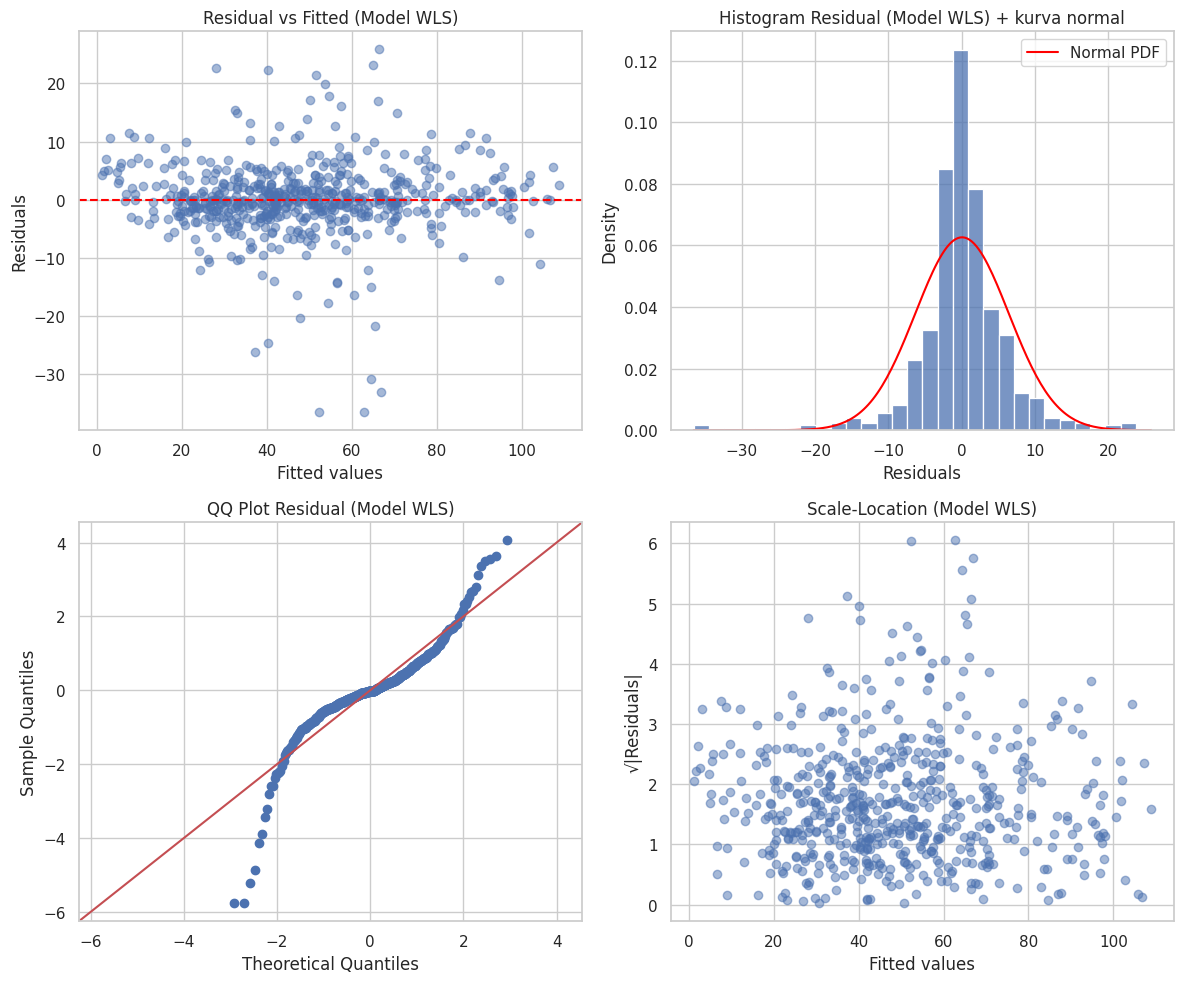

In [73]:
y_train_pred_W = wls_model.predict(X_train_const_W)
check_assumptions_and_plot(wls_model, X_train_const_W, y_train_pred_W,
                           title_prefix="Model WLS")


In [74]:
# PREPARASI TEST (sama seperti Model A/B)
test_processed = test_df.copy()

for col in cat_cols:
    if col in test_processed.columns and f"{col}_mode" in train_stats:
        test_processed[col] = test_processed[col].fillna(train_stats[f"{col}_mode"])

for col in num_cols:
    if col in test_processed.columns and f"{col}_median" in train_stats:
        test_processed[col] = test_processed[col].fillna(train_stats[f"{col}_median"])

test_X = test_processed[feature_cols].copy()
test_X_encoded = pd.get_dummies(test_X, columns=cat_cols, drop_first=True)
test_X_encoded = test_X_encoded.reindex(columns=base_cols, fill_value=0)

# Tambah fitur polynomial & interaksi (sama persis dengan train)
test_X_poly = test_X_encoded.copy()

for col in ["x1", "x8", "x9", "x10"]:
    if col in test_X_poly.columns:
        test_X_poly[f"{col}_sq"] = test_X_poly[col]**2

if "x1" in test_X_poly.columns and "x8" in test_X_poly.columns:
    test_X_poly["x1_x8"] = test_X_poly["x1"] * test_X_poly["x8"]
if "x1" in test_X_poly.columns and "x9" in test_X_poly.columns:
    test_X_poly["x1_x9"] = test_X_poly["x1"] * test_X_poly["x9"]
if "x8" in test_X_poly.columns and "x9" in test_X_poly.columns:
    test_X_poly["x8_x9"] = test_X_poly["x8"] * test_X_poly["x9"]

# Samakan kolom dengan X_train_W
test_X_poly = test_X_poly.reindex(columns=X_train_W.columns, fill_value=0)
test_X_const_W = sm.add_constant(test_X_poly).astype(float)

# Prediksi WLS
y_test_W = wls_model.predict(test_X_const_W)

submission_WLS = pd.DataFrame({
    "ID": np.arange(1, len(y_test_W) + 1),
    "y": y_test_W
})
submission_WLS.to_csv("submission_WLS_poly.csv", index=False)
print("submission_WLS_poly.csv berhasil dibuat")
print(submission_WLS.head())

submission_WLS_poly.csv berhasil dibuat
   ID           y
0   1   72.353681
1   2   84.014558
2   3   60.006381
3   4   71.867974
4   5  119.912115


## QUANTILE REGRESSION (MEDIAN REGRESSION)

In [75]:
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.metrics import mean_squared_error

# Gunakan pembagian data yang sama dengan WLS/Model A
qr_model = QuantReg(y_train_W, X_train_const_W).fit(q=0.5)
print("\n" + "="*70)
print("MODEL QUANTILE REGRESSION (q = 0.5, median)")
print("="*70)
print(qr_model.summary())

# Evaluasi MSE terhadap nilai y (mean-based metric meski model median)
y_train_pred_Q = qr_model.predict(X_train_const_W)
y_val_pred_Q   = qr_model.predict(X_val_const_W)

mse_train_Q = mean_squared_error(y_train_W, y_train_pred_Q)
mse_val_Q   = mean_squared_error(y_val_W,   y_val_pred_Q)

print("\nMSE Train (Quantile q=0.5):     ", mse_train_Q)
print("MSE Validation (Quantile q=0.5):", mse_val_Q)


MODEL QUANTILE REGRESSION (q = 0.5, median)
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.7891
Model:                       QuantReg   Bandwidth:                       2.192
Method:                 Least Squares   Sparsity:                        8.005
Date:                Tue, 30 Dec 2025   No. Observations:                  588
Time:                        10:22:21   Df Residuals:                      567
                                        Df Model:                           20
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.1030      2.586      7.387      0.000      14.023      24.183
x1             2.4032      0.062     38.653      0.000       2.281       2.525
x4            -0.0088      0.158     -0.056      0.955      -0.318       0.301
x7     

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



UJI ASUMSI KLASIK (Model Quantile Reg q=0.5)

[A] Uji Normalitas (Jarque-Bera)
    Statistik: 1711.8780
    p-value :  0.000000

[B] Uji Multikolinearitas (VIF)
Variabel        VIF
   const 245.461793
      x1  27.638524
      x4   1.019002
      x7   1.024571
      x8  45.824980
      x9  42.497086
     x10  17.531323
    x2_E   1.238276
    x2_M   1.233969
    x2_N   1.167177
    x5_L   1.893572
    x5_M   1.846225
    x6_R   1.039503
    x6_S   1.033895
   x1_sq  13.911174
   x8_sq  38.032858
   x9_sq  38.522118
  x10_sq  17.571074
   x1_x8  13.545321
   x1_x9  13.509821
   x8_x9  20.448027
    VIF Maksimum (abaikan const): 245.4618

[C] Uji Heteroskedastisitas (Breusch-Pagan)
    LM Statistik: 37.1921
    p-value    :  0.011096

[D] Uji Autokorelasi (Durbin-Watson)
    DW Statistik: 2.0710


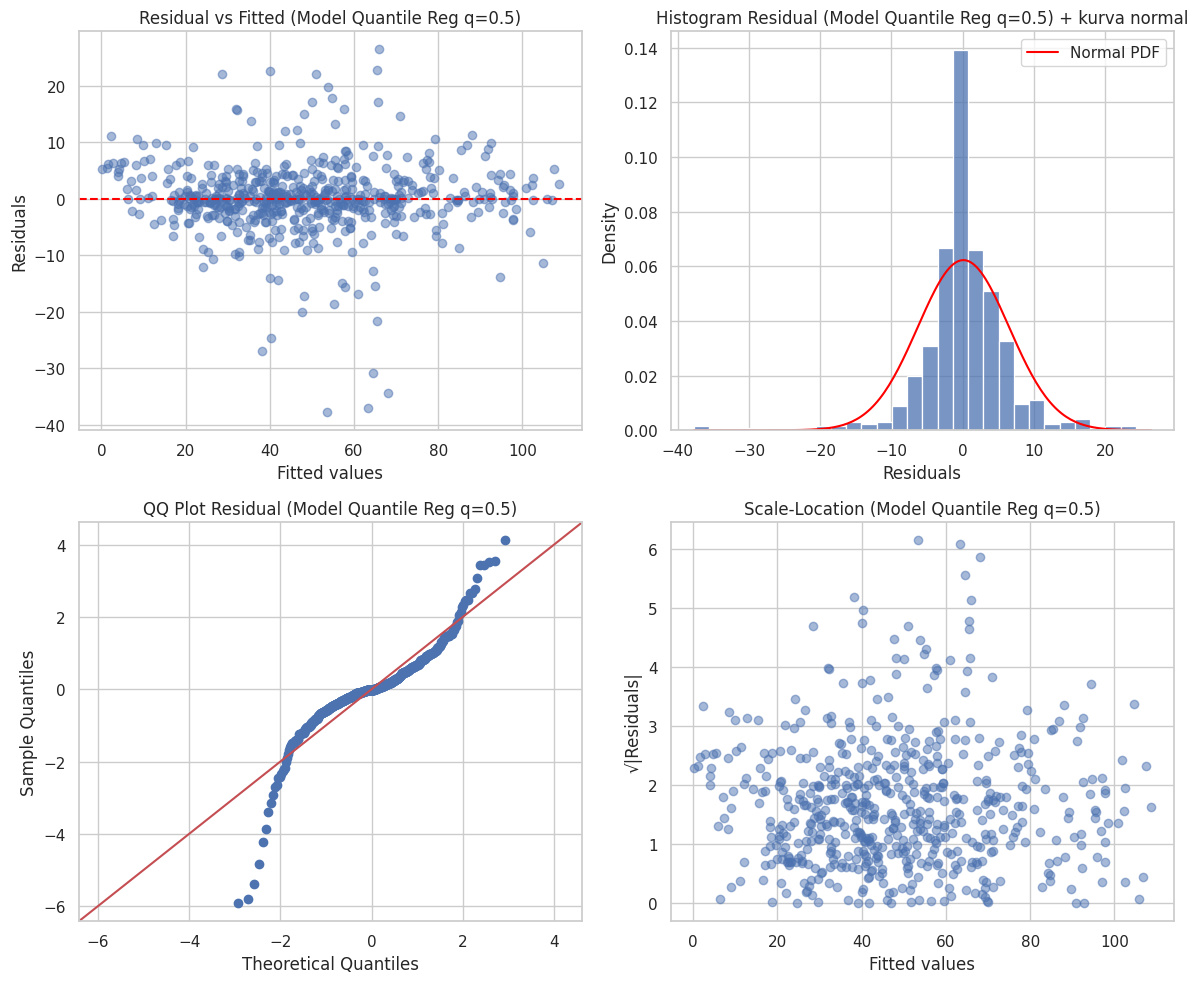

In [76]:
# y_train_pred_Q sudah dihitung di Cell Q1
check_assumptions_and_plot(qr_model, X_train_const_W, y_train_pred_Q,
                           title_prefix="Model Quantile Reg q=0.5")

In [77]:
# PREPARASI TEST SAMA PERSIS DENGAN WLS / Model A
test_processed = test_df.copy()

for col in cat_cols:
    if col in test_processed.columns and f"{col}_mode" in train_stats:
        test_processed[col] = test_processed[col].fillna(train_stats[f"{col}_mode"])

for col in num_cols:
    if col in test_processed.columns and f"{col}_median" in train_stats:
        test_processed[col] = test_processed[col].fillna(train_stats[f"{col}_median"])

test_X = test_processed[feature_cols].copy()
test_X_encoded = pd.get_dummies(test_X, columns=cat_cols, drop_first=True)

# Samakan kolom dasar dengan base_cols (X_full_encoded)
test_X_encoded = test_X_encoded.reindex(columns=base_cols, fill_value=0)

# Tambah fitur polynomial & interaksi sama seperti train
test_X_poly = test_X_encoded.copy()

for col in ["x1", "x8", "x9", "x10"]:
    if col in test_X_poly.columns:
        test_X_poly[f"{col}_sq"] = test_X_poly[col]**2

if "x1" in test_X_poly.columns and "x8" in test_X_poly.columns:
    test_X_poly["x1_x8"] = test_X_poly["x1"] * test_X_poly["x8"]
if "x1" in test_X_poly.columns and "x9" in test_X_poly.columns:
    test_X_poly["x1_x9"] = test_X_poly["x1"] * test_X_poly["x9"]
if "x8" in test_X_poly.columns and "x9" in test_X_poly.columns:
    test_X_poly["x8_x9"] = test_X_poly["x8"] * test_X_poly["x9"]

# Samakan kolom dengan X_train_W yang dipakai di qr_model
test_X_poly = test_X_poly.reindex(columns=X_train_W.columns, fill_value=0)
test_X_const_W = sm.add_constant(test_X_poly).astype(float)

# Prediksi quantile regression (median)
y_test_Q = qr_model.predict(test_X_const_W)

submission_Q = pd.DataFrame({
    "ID": np.arange(1, len(y_test_Q) + 1),
    "y": y_test_Q
})
submission_Q.to_csv("submission_Quantile_median.csv", index=False)
print("submission_Quantile_median.csv berhasil dibuat")
print(submission_Q.head())

submission_Quantile_median.csv berhasil dibuat
   ID           y
0   1   73.122541
1   2   85.291747
2   3   59.772179
3   4   71.517452
4   5  120.180213
